В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dariadubovska
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 81.1MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


Area under ROC score on Train dataset: 0.88%


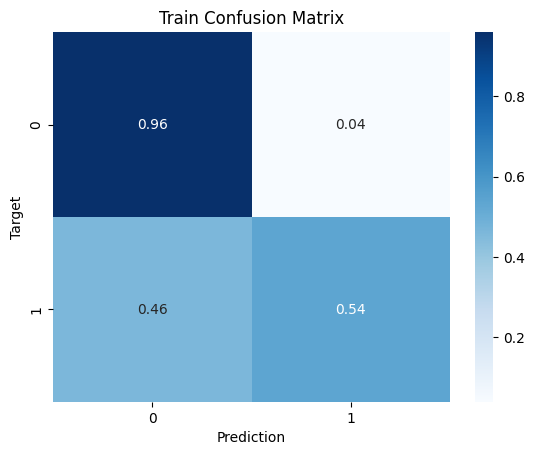

Area under ROC score on Validation dataset: 0.88%


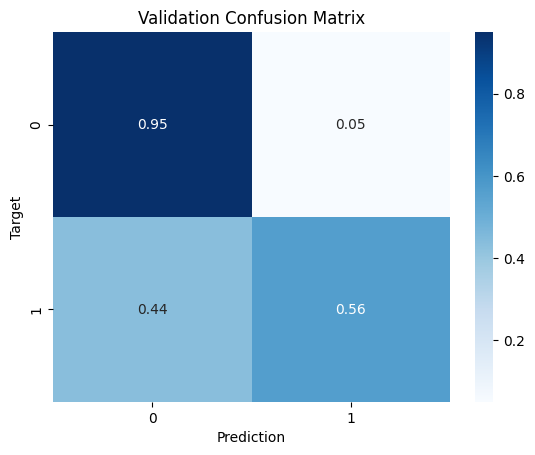

['bank_castomer_pipeline.joblib']

In [4]:
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2' + '/train.csv', index_col=0)


train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = train_df.columns.drop('Exited')
target_col = target_col = 'Exited'
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# видаляжмо колонки, які вважаємо не потрібними
train_inputs = train_inputs.drop(columns=['CustomerId', 'Surname'])
val_inputs = val_inputs.drop(columns=['CustomerId', 'Surname'])

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.difference(['id']).tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)

    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")

    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')

    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline,train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'bank_castomer_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.92%


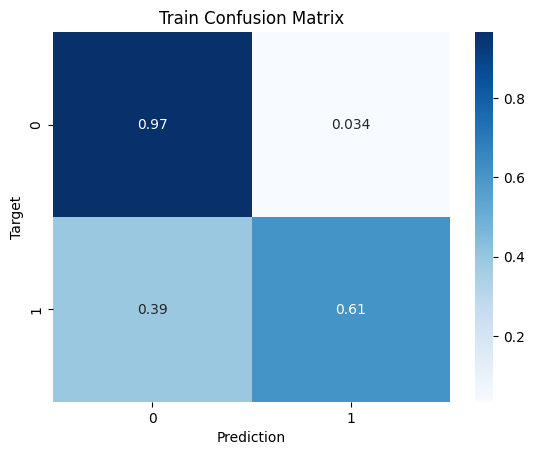

Area under ROC score on Vаlidation dataset: 0.92%


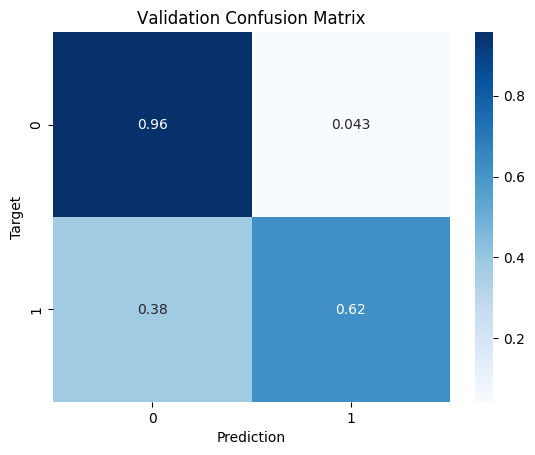

In [5]:
numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly.fit(train_inputs, train_targets)

train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Train')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Vаlidation')

**Спостереження**

Метрики моделі на тернувальному і на валідаційному наборі даних дуже близькі, тож модемо зробити висновок, що модель добре генералізує дані. В моделі не спостерігаємно  overfit чи underfit.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.93%


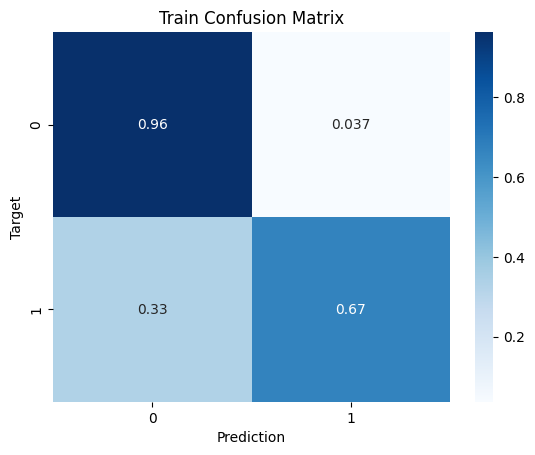

Area under ROC score on Vаlidation dataset: 0.93%


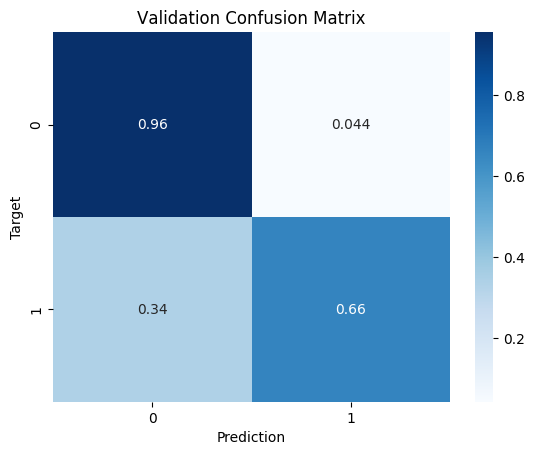

In [6]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4))
])

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly4.fit(train_inputs, train_targets)

train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Vаlidation')

**Спостереження**

Метрики моделі на тернувальному і на валідаційному наборі даних дуже близькі, тож модемо зробити висновок, що модель добре генералізує дані. В моделі не спостерігаємно  overfit чи underfit. При тому, метрики цієї моделі кращі ніж у попередньої

In [7]:
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2' + '/test.csv')

test_raw_df = test_raw_df.drop(columns=['CustomerId', 'Surname'])

test_pred_proba = model_pipeline_poly4.predict_proba(test_raw_df)[:, 1]
print(test_pred_proba)
test_raw_df['Exited'] = test_pred_proba

[0.07863733 0.02025488 0.07018374 ... 0.00478366 0.13163272 0.08906992]


In [8]:
sample_submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-2' + '/sample_submission.csv')
sample_submission_df['Exited'] = test_raw_df['Exited']
sample_submission_df.to_csv('submission.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [29]:
regression_df = pd.read_csv('regression_data.csv')
regression_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [30]:
reg_train_df, reg_test_df = train_test_split(regression_df, test_size=0.2, random_state=42)
reg_train_inputs = reg_train_df.drop(columns=['target'])
reg_train_targets = reg_train_df['target']
reg_test_inputs = reg_test_df.drop(columns=['target'])
reg_test_targets = reg_test_df['target']

In [34]:
scaler = StandardScaler()
reg_train_inputs = scaler.fit_transform(reg_train_inputs)
reg_test_inputs = scaler.transform(reg_test_inputs)

In [38]:
lin_model = LinearRegression()
lin_model.fit(reg_train_inputs, reg_train_targets)

y_pred_train = lin_model.predict(reg_train_inputs)
y_pred_test = lin_model.predict(reg_test_inputs)

print('Train RMSE: ', root_mean_squared_error(reg_train_targets, y_pred_train))
print('Test RMSE: ', root_mean_squared_error(reg_test_targets, y_pred_test))

print("Train R²:", r2_score(reg_train_targets, y_pred_train))
print("Test R²:", r2_score(reg_test_targets, y_pred_test))

Train RMSE:  1.0664716922463602
Test RMSE:  0.8833273761660406
Train R²: 0.9994160875267106
Test R²: 0.999665561359872


In [39]:
poly_features = PolynomialFeatures(degree=5)
X_train_poly = poly_features.fit_transform(reg_train_inputs)
X_test_poly = poly_features.transform(reg_test_inputs)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, reg_train_targets)
y_pred_train_poly = poly_reg.predict(X_train_poly)
y_pred_test_poly = poly_reg.predict(X_test_poly)

print('Train RMSE: ', root_mean_squared_error(reg_train_targets, y_pred_train_poly))
print('Test RMSE: ', root_mean_squared_error(reg_test_targets, y_pred_test_poly))

print("Train R²:", r2_score(reg_train_targets, y_pred_train_poly))
print("Test R²:", r2_score(reg_test_targets, y_pred_test_poly))

Train RMSE:  3.7763558710745e-13
Test RMSE:  35.62805277364273
Train R²: 1.0
Test R²: 0.4559269150836144


**Спостереження**

Перша модель:
* метрики на трейні і тесті схожі
* модель добре герералізує, немає овер чи андерфіту
* тест R2 демонтрує дуже гарну точність прогнозування моделі

Дргуа модель:
* явні ознаки пернавчення моделі - ідеальна підгонка під дані на трейні і значно гірший результат на тесті

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [41]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = round(root_mean_squared_error(y_train, y_train_pred), 6)
    val_metrics = round(root_mean_squared_error(y_val, y_val_pred), 6)

    return dict(train=train_metrics, val=val_metrics)

In [44]:
models = [
    Ridge(),
    Lasso(),
    ElasticNet(alpha=0.5)
]

poly_features20 = PolynomialFeatures(degree=20)
X_train_poly20 = poly_features20.fit_transform(reg_train_inputs)
X_test_poly20 = poly_features20.transform(reg_test_inputs)

for model in models:
  model.fit(X_train_poly20, reg_train_targets)
  eval_results = evaluate_model(model, X_train_poly20, reg_train_targets, X_test_poly20, reg_test_targets)
  print(f'{str(model)}: {eval_results}\n')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ridge(): {'train': 30.879122, 'val': 152443.031595}



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.355e+03, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(): {'train': 2.19752, 'val': 14.944979}

ElasticNet(alpha=0.5): {'train': 7.072921, 'val': 94.628166}



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.546e+03, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


**Спостереження**

В цих моделях спостерігаємо пенавчання: бічимо, що на тесті помилка в рази вища за помилку на трейні.

Лінійна регресія без поліномів показала найкращій результат. Вона найкраще з усіх генералізує дані.